## Table of Contents

1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model
6. Evaluate the best model on the testing set
7. Deep Learning Model



----------------------------------------------------------------------------------
----------------------------------------------------------------------------------

### Problem Description --> Predict Sentiments of Tweets
________________________________________


Given dataset contains data of tweets on various airline’s twitter handles.
It contains a total of 12 columns, out of which one column specifies the sentiment of the tweet. All other columns provide various information related to what was the tweet, where was it posted from, when was it posted, it's retweeted; etc.
**Your task is to build a machine learning / deep learning model to predict the sentiment of the tweet using all or some of the other given columns.**

Description of columns of the dataset is given below - 

|Sr No|Column name|Description|
|------|------|------|------|
|1. |tweet_id  |Id of the tweet  |
|**2.**|**airline_sentiment**|**Sentiment of the tweet (Target variable)**|
|3.|	airline_sentiment_confidence	|Confidence with which the given sentiment was determined|
|4.	|negativereason_confidence	|Confidence with which the negative reason of tweet was predicted|
|5.	|name	|Name of the person who tweeted|
|6.	|retweet_count	|Number of retweets|
|7.	|text	|Text of the tweet whose sentiment has to be predicted|
|8.	|tweet_created	|Time at which the tweet was created|
|9.	|tweet_location	|Location from where the tweet was posted|
|10.	|user_timezone	|Time zone from where the tweet was posted|
|11.	|negativereason	|Reason for which user posted a negative tweet|
|12.	|airline	|Airline for which the tweet was posted|


Following are the files that will be provided in the dataset -
    1. train.csv  - This file contains all the above-mentioned columns. You are expected to train your models on this file.
    2. test.csv  - This file contains all the above-mentioned columns except “airline_sentiment” column. You have to predict this column for each record given in this file.
    3. sample_submission.csv  - This file consists of sample submissions. Your submission should be in exact same format.


### 1--> Data cleaning and formatting

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

#### Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#### Features Creation
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

#### Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB

#### Plotting
import matplotlib.pyplot as plt
import seaborn as sns


#### Model Validation
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data_path = Path('..', '01.Data')
data = pd.read_csv(data_path / 'train.csv', index_col=0)

data.head(3)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,
Tr_tweet_1,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0.0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
Tr_tweet_2,positive,0.3486,NaN,0.0,Virgin America,jnardino,0.0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
Tr_tweet_3,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0.0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [3]:
#### Summary Function (no. of null value, unique count for each columns)
def summary_fun(data):
    cols = list(data.columns)
    n_unique = []
    null_per = []
    distinct =  []
    l = len(data)
    for col in cols:
        n_unique.append(data[col].nunique())
        a = round(100*(data[col].isnull().sum()/l),2)
        b = round(100*(data[col].nunique()/l),2)
        null_per.append(a)
        distinct.append(b)
        
    ans = pd.DataFrame()
    ans['Var'] = cols 
    ans['n_unique'] = n_unique
    ans['null_per(%)'] = null_per
    ans['distinct_per(%)'] = distinct
    ans.index = range(1,len(ans)+1)
    
    return ans.head(100) 

In [4]:
summary_fun(data)

## we are only consider text column. So, no pre-process((Missing Data and Outliers) steps required as text columns 
## contains few null value

,Var,n_unique,null_per(%),distinct_per(%)
1,airline_sentiment,3,0.00,0.09
2,airline_sentiment_confidence,523,0.00,15.66
3,negativereason,10,36.09,0.30
4,negativereason_confidence,729,26.62,21.83
5,airline,2,0.03,0.06
6,name,1925,0.03,57.65
7,retweet_count,5,0.03,0.15
8,text,3321,0.03,99.46
9,tweet_created,3227,2.88,96.65
10,tweet_location,1010,30.55,30.25


### 2--> Exploratory data analysis

1. Tweets Classification Problem
2. Binary classification Problem

In [5]:
## Target Value Analysis
## Target value can take 3 values (negative, neural, and positive). Hence, its a multiclass problem
data.airline_sentiment.value_counts()

negative    2135
neutral      679
positive     525
Name: airline_sentiment, dtype: int64

In [6]:
## For all negative comenmts, reason is provided. So, we can directly tag negative comments. Now, problem convert to binary 
## classification problem
data.groupby(['airline_sentiment'])['negativereason'].count()

airline_sentiment
negative    2134
neutral        0
positive       0
Name: negativereason, dtype: int64

In [7]:
data_pn  = data[data.airline_sentiment!="negative"]
data_pn.airline_sentiment.value_counts()

neutral     679
positive    525
Name: airline_sentiment, dtype: int64

In [8]:
summary_fun(data_pn)

,Var,n_unique,null_per(%),distinct_per(%)
1,airline_sentiment,2,0.00,0.17
2,airline_sentiment_confidence,359,0.00,29.82
3,negativereason,0,100.00,0.00
4,negativereason_confidence,1,73.75,0.08
5,airline,2,0.00,0.17
6,name,927,0.00,76.99
7,retweet_count,5,0.00,0.42
8,text,1189,0.00,98.75
9,tweet_created,1161,3.16,96.43
10,tweet_location,547,27.49,45.43


### 3--> Feature engineering and selection

1. Representing text as numerical data
2. Vectorizing our dataset

In [9]:
text_data = data_pn[['text','airline_sentiment']]

In [10]:
###### Pre-Processing Function 
import re
from textblob import Word
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
stop = stopwords.words('english')

def pre_process(name,Stemming=False,Lemmatization=False):
    
    #1. remove . " ' ( ) 
    name = re.sub("[\"\'.()\[\]\{\}<>`\?\!#\$%^\&=@]", " ", name)
    name = re.sub('https?://[A-Za-z0-9./]+','',name)
    name = re.sub("[,;:\+/\\\*~\|]", " ", name)
    
    #2. replace multiple spaces with single space
    name = " ".join(name.strip().split())
    
    #3. convert string to lower case
    name = name.lower()
    
    #4. Removal of stop words
    name =  " ".join(x for x in name.split() if x not in stop)
    
    #5. Stemming
    if (Stemming):
        name = " ".join([st.stem(name) for name in x.split()])
        
    #6. Lemmatization
    if (Lemmatization):
        name = " ".join([Word(word).lemmatize() for word in name.split()])
        
    return name

[nltk_data] Downloading package wordnet to
[nltk_data]     /home1/shubhamg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
#### Features Creation Function 
#### Using Tf & Idf on word_gram and character

def TF_IDF(data,name,char=False):
    
    word_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        analyzer='word',
        token_pattern=r'\w{1,}',
        stop_words='english',
        ngram_range=(1, 2),
        max_features=100000,
        use_idf=False)
    word_vectorizer.fit(data[name])
    
    features_word = word_vectorizer.transform(data[name])
    a = list(word_vectorizer.vocabulary_.keys())
    word_vol = ["W_" + s for s in a]

    if (char):
        char_vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='char',
            stop_words='english',
            ngram_range=(2, 4),
            max_features=50000,
            use_idf=False)
        char_vectorizer.fit(data[name])
        features_char = char_vectorizer.transform(data[name])
        
        features = hstack([features_word, features_char])
        
        b = list(char_vectorizer.vocabulary_.keys())
        char_vol = ["C_" + s for s in b]
        feature_cols = word_vol + char_vol
    else: 
        features = features_word
        feature_cols = word_vol
        
    return features,word_vectorizer, feature_cols

In [12]:
text_data['text_pre'] = text_data['text'].apply(pre_process,Lemmatization=True)
features,word_vectorizer,feature_cols = TF_IDF(text_data,'text_pre')
features = pd.DataFrame(features.todense())
features.columns = feature_cols
text_data['target'] = np.where(text_data.airline_sentiment =="positive",1,0)
target = text_data.target
features.shape

(1204, 9707)

### 4--> Compare several machine learning models on a performance metric



*Observations*
1. Performance of MultinomialNB is better than any other model
2. Select MultinomialNB as final model
3. Model is slightly overfit; Training score is more than testing score

In [13]:
#### Model Selection Function 

def models_validation(features,target,k=5, LR=False, SVM = False, MNB = False, DT=False, RF=False,\
                      gbc=False,xgb=False,plot_train=False):
    
    kf = KFold(n_splits=k)
    count=0
    target.index = range(len(target))
    features.index = range(len(features))
    
    entries = []
    models = []
    
    if (LR):
        models.append(LogisticRegression())
        
    if (SVM):
        models.append(svm.SVC())
    
    if (DT):
        models.append(MultinomialNB(alpha=1))
        
    if (DT):
        models.append(tree.DecisionTreeClassifier(max_depth=4, random_state=0))
        
    if(RF):
        models.append(RandomForestClassifier(n_estimators=50, max_depth=4, random_state=0))
        
    if(gbc):
        models.append(GradientBoostingClassifier())
        
   
    if(xgb):
        models.append(XGBClassifier(random_state=42, learning_rate = 0.05, n_estimators = 100, \
                       max_depth = 5, min_child_weight = 4,gamma=0.4,subsample=1 ,colsample_bytree=0.6, reg_alpha=0.1))
        

    cv_df = pd.DataFrame(index=range(k * len(models)))
    for model in models:
        model_name = model.__class__.__name__
        count=0
        for train, test in kf.split(target):
            count+=1
            X_train, X_test, y_train, y_test = features.iloc[train], features.iloc[test], target[train], target[test]
            model.fit(X_train, y_train) 
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            error_test = round(f1_score(y_test, y_pred),2)  
            error_train = round(f1_score(y_train, y_pred_train),2)
            entries.append((model_name,count,error_test,error_train))
            
        print ("Done-->", model_name)
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_test','f1_train'])
    results = cv_df.groupby(['model_name'])['f1_test','f1_train'].mean().round(2)
    
    sns.boxplot(x='model_name', y='f1_test', data=cv_df)
    sns.stripplot(x='model_name', y='f1_test', data=cv_df, size=10, jitter=True, edgecolor="gray", linewidth=2)
    plt.title('Error-->Test Data')
    plt.figure(figsize=(100,100))
    plt.show()
    
    if (plot_train):
        sns.boxplot(x='model_name', y='f1_train', data=cv_df)
        sns.stripplot(x='model_name', y='f1_train', data=cv_df, size=10, jitter=True, edgecolor="gray", linewidth=2)
        plt.title('Error-->Train Data')
        plt.show()
        
    return results, cv_df

Done--> LogisticRegression
Done--> MultinomialNB
Done--> DecisionTreeClassifier
Done--> GradientBoostingClassifier


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Done--> XGBClassifier


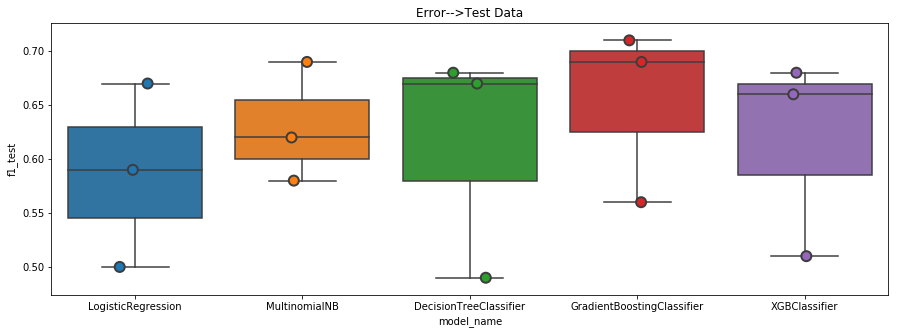

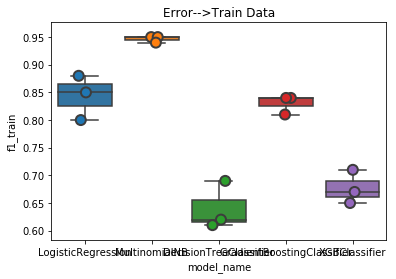

,f1_test,f1_train
model_name,,
DecisionTreeClassifier,0.61,0.64
GradientBoostingClassifier,0.65,0.83
LogisticRegression,0.59,0.84
MultinomialNB,0.63,0.95
XGBClassifier,0.62,0.68


In [14]:
plt.figure(figsize=(15,5))
results, cv_df = models_validation(features,target,LR=True, SVM = False, MNB = True, DT=True, RF=False,\
                      gbc=True,xgb=True,plot_train=True,k=3)
results

### 5--> Perform hyperparameter tuning on the best model

*Observations*

1. Best Score (f1_score)--> 0.7345
2. Best Parameters set -->  {alpha : 0.25}

In [15]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

Best Score -->  0.734
Best Parameters -->  0.25


Text(0,0.5,'f1_score-->')

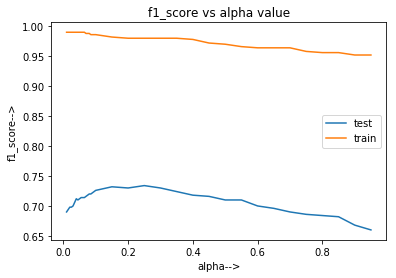

In [16]:
params_list = list(frange(0.01,0.1,0.005)) + list(frange(0.1,1,0.05))
target.index = range(len(target))
features.index = range(len(features))
entries = []
for alpha_value in params_list:
    model = MultinomialNB(alpha=alpha_value)
    kf = KFold(n_splits=5)
    count=0
    
    for train, test in kf.split(target):
        count+=1
        X_train, X_test, y_train, y_test = features.iloc[train], features.iloc[test], target[train], target[test]
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        error_test = round(f1_score(y_test, y_pred),2)  
        error_train = round(f1_score(y_train, y_pred_train),2)
        entries.append((alpha_value,count,error_test,error_train))

results = pd.DataFrame(entries)
results.columns = ['value','count','test','train']
results = results.groupby(['value'])['test','train'].mean().reset_index()
best_score = max(results.test)
best_params = list(results[results.test==best_score]['value'])[0]
print ("Best Score --> ",best_score)
print ("Best Parameters --> ",best_params)

plt.plot(results.value, results.test)
plt.plot(results.value, results.train)
plt.legend(['test','train'])
plt.title('f1_score vs alpha value')
plt.xlabel('alpha-->')
plt.ylabel('f1_score-->')

### 6--> Evaluate the best model on the testing set

|Confusion Matrix |
|----|----|
|TP | FP|
|FN | TN|



In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
model = MultinomialNB(alpha=best_params)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
f1_score_value = f1_score(y_test,y_pred)
print ("f1_score-->", f1_score_value)
print (" ")
print ("acc-->", accuracy_score(y_test,y_pred))
print (" ")
print ("confusion matrix")
print (confusion_matrix(y_test,y_pred))

f1_score--> 0.7648902821316615
 
acc--> 0.7928176795580111
 
confusion matrix
[[165  42]
 [ 33 122]]


### 7-->Deep Learning Model


In [18]:
from keras.preprocessing.text import Tokenizer          # for tokenizing text
from keras.preprocessing.sequence import pad_sequences  # for padding sentences with zeros. To make the sentence length same
from keras.utils import to_categorical                  # for one-hot encoding of the labels
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, Embedding
from keras.models import Sequential

Using TensorFlow backend.


In [19]:
print('Training model.')
EMBEDDING_DIM = 200
MAX_SEQUENCE_LENGTH = 200   # Sequence length of each sentence. If more, crop. If less, pad with zeros
MAX_NB_WORDS = 9000        # Top 9000 frequently occuring words

Training model.


In [20]:
#X_train, X_test, y_train, y_test = train_test_split(text_data['text_pre'], text_data['airline_sentiment'], test_size=0.3, random_state=42)

X_train  = text_data.iloc[X_train.index]
X_test  = text_data.iloc[X_test.index]
y_train  = text_data.iloc[y_train.index]['target']
y_test  = text_data.iloc[y_test.index]['target']

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)   # get the frequently occuring words
tokenizer.fit_on_texts(X_train.text_pre)           
train_sequences = tokenizer.texts_to_sequences(X_train.text_pre)
test_sequences = tokenizer.texts_to_sequences(X_test.text_pre)

word_index = tokenizer.word_index               # dictionary containing words and their index
# print(tokenizer.word_index)                   # print to check
print('Found %s unique tokens.' % len(word_index)) # total words in the corpus
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH) # get only the top frequent words on train
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)   # get only the top frequent words on test

print(train_data.shape)
print(test_data.shape)

Found 2412 unique tokens.
(842, 200)
(362, 200)


In [21]:

print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', y_train.shape)
print('Shape of label tensor:', y_test.shape)


print('Training model.')
EMBEDDING_DIM = 300

model = Sequential()
model.add(Embedding(MAX_NB_WORDS,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH
                    ))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(GlobalMaxPool1D())
# model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Shape of data tensor: (842, 200)
Shape of label tensor: (842,)
Shape of label tensor: (362,)
Training model.


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          2700000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,804,513
Trainable params: 2,804,513
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1])

model.fit(train_data, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(test_data, y_test))


#model.evaluate(test_data, labels_test)
y_pred = model.predict_classes(test_data)

y_test1 = list(y_test)
f1_score_value = f1_score(y_test1,y_pred)
print ("f1_score-->", f1_score_value)
print (" ")
print ("acc-->", accuracy_score(y_test1,y_pred))
print (" ")
print ("confusion matrix")
print (confusion_matrix(y_test1,y_pred))

Train on 842 samples, validate on 362 samples
Epoch 1/10
842/842 [==============================] - 2s 2ms/step - loss: 0.6895 - f1: 0.0548 - val_loss: 0.6768 - val_f1: 0.0000e+00
Epoch 2/10
842/842 [==============================] - 1s 2ms/step - loss: 0.6279 - f1: 0.6963 - val_loss: 0.6005 - val_f1: 0.5045
Epoch 3/10
842/842 [==============================] - 1s 2ms/step - loss: 0.3588 - f1: 0.8821 - val_loss: 0.5212 - val_f1: 0.6413
Epoch 4/10
842/842 [==============================] - 1s 2ms/step - loss: 0.1504 - f1: 0.9196 - val_loss: 0.5697 - val_f1: 0.6976
Epoch 5/10
842/842 [==============================] - 1s 2ms/step - loss: 0.0815 - f1: 0.9590 - val_loss: 0.6642 - val_f1: 0.7052
Epoch 6/10
842/842 [==============================] - 1s 2ms/step - loss: 0.0618 - f1: 0.9573 - val_loss: 0.7152 - val_f1: 0.6971
Epoch 7/10
842/842 [==============================] - 1s 2ms/step - loss: 0.0572 - f1: 0.9667 - val_loss: 0.7652 - val_f1: 0.6688
Epoch 8/10
842/842 [====================